In [3]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

In [2]:
!pip install -q kaggle
print("Please upload your kaggle.json key")
from google.colab import files
files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Please upload your kaggle.json key


Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
%%capture
! kaggle datasets download 'sigfest/database-for-emotion-recognition-system-gameemo'
! unzip database-for-emotion-recognition-system-gameemo.zip

# /content/database-for-emotion-recognition-system-gameemo.zip



In [9]:
path = r'/home/paul-dutton/.cache/kagglehub/datasets/sigfest/database-for-emotion-recognition-system-gameemo/versions/1/GAMEEMO'
# '/content/GAMEEMO' # if on colab

In [6]:
!pip install mne
!pip install pymatreader
import mne

  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
  Using cached pooch-1.8.2-py3-none-any.whl.metadata (10 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 11.4 MB/s eta 0:00:00 MB/s eta 0:00:01:01
Using cached lazy_loader-0.4-py3-none-any.whl (12 kB)
Using cached pooch-1.8.2-py3-none-any.whl (64 kB)


In [7]:
import mne

In [ ]:
#FOR EX: If we want to access only the first 10 time points of channel 8 we would use:
"""
print(raw._data[8, :11])
print(type(raw._data))
print(raw._data.shape)
"""

In [10]:
def get_patient(pn):
  X = [] # data
  y = [] # labels
  for g in range(1, 5):
    g = str(g)
    test_csv = os.path.join(path, f'(S{pn})/Preprocessed EEG Data/.csv format/S{pn}G{g}AllChannels.csv')
    df = pd.read_csv(test_csv)
    df = df.drop(columns=['Unnamed: 14'])
    col_names = list(df.columns)
    mne_info = mne.create_info(col_names, sfreq=128, ch_types='eeg') # sr should mean 5min result
    raw = mne.io.RawArray(df.transpose(), mne_info)
    raw.set_montage('standard_1005')
    #raw.compute_psd().plot()
    X.append(raw._data)
    y.append(g)
  return X, y

get_patient(11)

Creating RawArray with float64 data, n_channels=14, n_times=38252
    Range : 0 ... 38251 =      0.000 ...   298.836 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=38252
    Range : 0 ... 38251 =      0.000 ...   298.836 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=38252
    Range : 0 ... 38251 =      0.000 ...   298.836 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=38252
    Range : 0 ... 38251 =      0.000 ...   298.836 secs
Ready.


([array([[  9.1588,   7.6454,   1.1609, ...,   4.9624,  -3.7712, -12.9451],
         [ -4.8205,  -6.9414,  -9.6586, ...,   1.1039,  -4.0238,  -4.5053],
         [ 20.7284,  11.7719,  15.6447, ...,  -4.6647,  -3.6617,  -9.4676],
         ...,
         [  4.3385,   4.5602,   7.4198, ...,   1.3582,   8.7485,   4.1262],
         [ -4.3385,  -4.5602,  -1.6352, ...,  -5.0825,  -1.1622,   3.9691],
         [ 10.6051,  14.3075,   5.4951, ...,   2.2563,   2.8441,  -2.3881]]),
  array([[-23.6207 , -14.0083 , -19.4348 , ...,   8.0576 ,   1.7898 ,
           -7.9588 ],
         [-21.6925 , -17.9804 , -16.902  , ...,   8.7568 ,  13.5338 ,
            5.9731 ],
         [-20.7282 , -24.7871 , -29.5664 , ..., -10.7091 ,  -3.3178 ,
           -4.5648 ],
         ...,
         [-38.5643 , -34.3223 , -34.6731 , ..., -13.1527 ,  -4.6505 ,
           -1.4796 ],
         [ 37.6    ,  26.6669 ,  20.2466 , ...,  -2.4561 ,   9.7426 ,
            0.48074],
         [ 24.1026 ,  26.5129 ,  21.0657 , ...,  -1.20

In [11]:
def get_all_patients():
  X = []
  y = []
  subject_ids = []
  for pn in tqdm(range(1, 29)):
    pn = str(pn).zfill(2)
    for g in range(1, 5):
      test_csv = os.path.join(path, f'(S{pn})/Preprocessed EEG Data/.csv format/S{pn}G{g}AllChannels.csv')
      df = pd.read_csv(test_csv)
      df = df.drop(columns=['Unnamed: 14'])
      col_names = list(df.columns)
      mne_info = mne.create_info(col_names, sfreq=128, ch_types='eeg') # sr should mean 5min result
      raw = mne.io.RawArray(df.transpose(), mne_info, verbose='CRITICAL')
      raw.set_montage('standard_1005')
      X.append(raw._data)
      y.append(g)
      subject_ids.append(pn)
  #return X, y, subject_ids
  return np.array(X), np.array(y), np.array(subject_ids)

In [12]:
datas, labels, subjects = get_all_patients()
datas.shape

100%|███████████████████████████████████████████| 28/28 [00:03<00:00,  8.01it/s]


(112, 14, 38252)

In [13]:
len(datas), datas[0].shape

(112, (14, 38252))

In [14]:
# CLAUDE 3.7 Sonnet
def extract_features(X):
    """
    Extract features from EEG data.

    Parameters:
    X (np.array): Raw EEG data with shape (n_samples, n_channels, n_timepoints)

    Returns:
    features (np.array): Extracted features with shape (n_samples, n_features)
    """
    n_samples = X.shape[0]
    features = []

    for i in range(n_samples):
        sample_features = []

        # For each channel, extract:
        # 1. Mean
        # 2. Standard deviation
        # 3. Min, Max
        # 4. Frequency domain features (if needed)

        # Mean and std for each channel
        channel_means = np.mean(X[i], axis=1)
        channel_stds = np.std(X[i], axis=1)

        # Min and max for each channel
        channel_mins = np.min(X[i], axis=1)
        channel_maxs = np.max(X[i], axis=1)

        # Combine features
        sample_features = np.concatenate([
            channel_means,
            channel_stds,
            channel_mins,
            channel_maxs
        ])

        features.append(sample_features)

    return np.array(features)

features = extract_features(datas)
features.shape, features

((112, 56),
 array([[ 1.36107224e-02,  6.08219408e-03,  4.38608942e-03, ...,
          5.56290000e+01,  1.14101300e+02,  5.63144000e+01],
        [ 1.03475354e-02,  3.08122091e-03,  2.40548920e-02, ...,
          5.41328000e+01,  2.26865200e+02,  4.20870000e+01],
        [ 1.22379994e-02,  2.76708327e-03,  1.92538069e-02, ...,
          8.31734000e+01,  9.45867000e+01,  4.31276000e+01],
        ...,
        [ 6.15980926e-04,  4.17026657e-03,  7.05672915e-03, ...,
          1.40896600e+02,  9.63592000e+01,  7.31873000e+01],
        [ 2.28642922e-03,  7.66382371e-03, -2.74298811e-03, ...,
          8.89611000e+01,  6.81332000e+01,  1.24924500e+02],
        [ 1.12802521e-02,  3.56101225e-02, -1.34141074e-02, ...,
          6.52470000e+01,  4.72132000e+01,  5.26304000e+01]]))

In [17]:
# CLAUDE 3.7 Sonnet
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
def train_evaluate_model(X, y, subject_ids, test_size=0.2, random_state=42):
    """
    Train and evaluate a classification model on the EEG data.
    Uses subject-wise splitting to ensure no data leakage.

    Parameters:
    X (np.array): Feature array
    y (np.array): Labels array
    subject_ids (np.array): Subject IDs array
    test_size (float): Proportion of data to use for testing
    random_state (int): Random seed for reproducibility

    Returns:
    model (Pipeline): Trained classification model
    test_accuracy (float): Accuracy on the test set
    """
    # Get unique subject IDs
    unique_subjects = np.unique(subject_ids)

    # Split subjects into train and test groups
    train_subjects, test_subjects = train_test_split(
        unique_subjects, test_size=test_size, random_state=random_state
    )

    # Create train and test masks based on subject IDs
    train_mask = np.isin(subject_ids, train_subjects)
    test_mask = np.isin(subject_ids, test_subjects)

    X_train, X_test = X[train_mask], X[test_mask]
    y_train, y_test = y[train_mask], y[test_mask]

    # Create and train the model
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(C=1.0, penalty='l2', solver='liblinear', max_iter=1000))
    ])

    # Train the model
    model.fit(X_train, y_train)

    # Evaluate
    train_accuracy = model.score(X_train, y_train)
    test_accuracy = model.score(X_test, y_test)

    print(f"Train accuracy: {train_accuracy:.3f}")
    print(f"Test accuracy: {test_accuracy:.3f}")

    # Detailed evaluation
    y_pred = model.predict(X_test)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return model, test_accuracy

Loading EEG dataset...


100%|███████████████████████████████████████████| 28/28 [00:03<00:00,  9.23it/s]


Dataset loaded: 112 samples, 4 classes
Samples per class: [28, 28, 28, 28]
Number of subjects: 28
Extracting features...
Features extracted: 56 features per sample
Training and evaluating model...
Train accuracy: 1.000
Test accuracy: 0.708

Classification Report:
              precision    recall  f1-score   support

           1       0.67      0.67      0.67         6
           2       0.83      0.83      0.83         6
           3       0.71      0.83      0.77         6
           4       0.60      0.50      0.55         6

    accuracy                           0.71        24
   macro avg       0.70      0.71      0.70        24
weighted avg       0.70      0.71      0.70        24



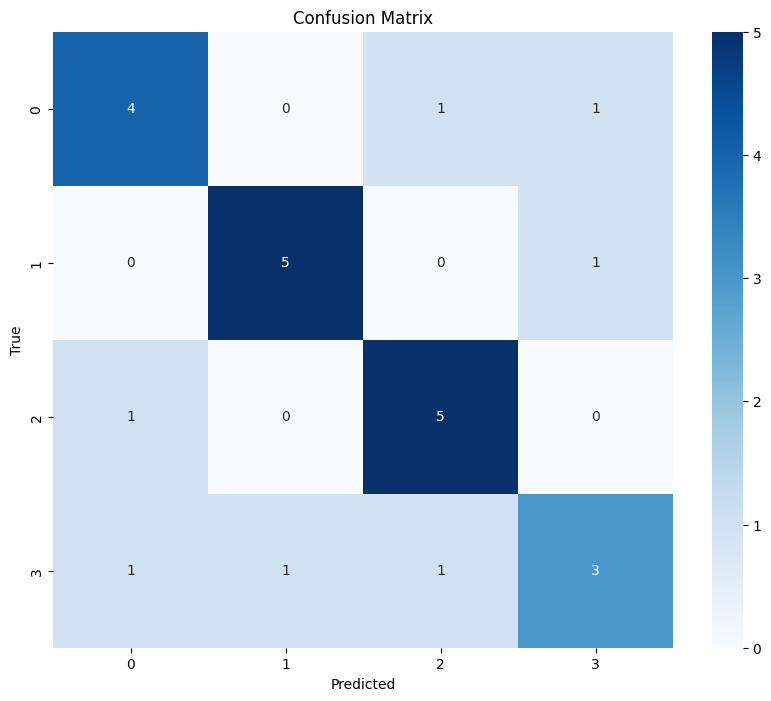

Final model accuracy: 0.708


In [18]:
# CLAUDE 3.7 Sonnet
print("Loading EEG dataset...")
X_raw, y, subject_ids = get_all_patients() #load_eeg_dataset(base_dir)

print(f"Dataset loaded: {X_raw.shape[0]} samples, {len(np.unique(y))} classes")
print(f"Samples per class: {pd.Series(y).value_counts().sort_index().tolist()}")
print(f"Number of subjects: {len(np.unique(subject_ids))}")

# Extract features
print("Extracting features...")
X_features = extract_features(X_raw)
print(f"Features extracted: {X_features.shape[1]} features per sample")

# Train and evaluate
print("Training and evaluating model...")
model, accuracy = train_evaluate_model(X_features, y, subject_ids)

print(f"Final model accuracy: {accuracy:.3f}")
#return model

In [19]:
def differentialEntropy(signal):
  # 1/2 * log(2 * pi * e *  σ 2 {\displaystyle \sigma ^{2}})
  variance = np.var(signal)
  return 1/2 * np.log(2 * np.pi * np.e * variance)

In [21]:
def separateBands(signal):
    ...

In [29]:
import os
import numpy as np
import pandas as pd
from glob import glob
from scipy import signal
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

def load_eeg_data(file_path):
    """
    Load EEG data from a CSV file.

    Parameters:
    -----------
    file_path : str
        Path to the CSV file containing EEG data

    Returns:
    --------
    eeg_data : numpy.ndarray
        EEG data with shape (n_channels, n_samples)
    """
    data = pd.read_csv(file_path)

    # Identify if first column is time/index
    if data.columns[0].lower() in ['time', 'index']:
        # Use columns except first as channels
        eeg_data = data.iloc[:, 1:].values.T  # Transpose to get channels x samples
    else:
        eeg_data = data.values.T

    return eeg_data

def extract_frequency_bands(eeg_data, fs, bands=None, order=4):
    """
    Extract standard frequency bands from EEG signal using bandpass filtering.

    Parameters:
    -----------
    eeg_data : numpy.ndarray
        EEG data array with shape (n_channels, n_samples)
    fs : float
        Sampling frequency in Hz
    bands : dict, optional
        Dictionary of frequency bands to extract.
    order : int, optional
        Order of the Butterworth filter.

    Returns:
    --------
    band_signals : dict
        Dictionary of band-limited signals for each frequency band
    """
    if bands is None:
        bands = {
            'delta': (1, 4),
            'theta': (4, 8),
            'alpha': (8, 13),
            'beta': (13, 30),
            'gamma': (30, 50)
        }

    n_channels, n_samples = eeg_data.shape
    band_signals = {}

    # Process each band
    for band_name, (low_freq, high_freq) in bands.items():
        # Normalize frequencies to Nyquist frequency
        nyq = 0.5 * fs
        low = low_freq / nyq
        high = high_freq / nyq

        # Design Butterworth bandpass filter
        b, a = signal.butter(order, [low, high], btype='bandpass')

        # Apply filter to each channel
        band_data = np.zeros_like(eeg_data)
        for ch in range(n_channels):
            # Use filtfilt for zero-phase filtering
            band_data[ch] = signal.filtfilt(b, a, eeg_data[ch])

        band_signals[band_name] = band_data

    return band_signals

def compute_band_powers(band_signals, window_size=None):
    """
    Compute absolute and relative power in each frequency band.

    Parameters:
    -----------
    band_signals : dict
        Dictionary of band-limited signals for each frequency band
    window_size : int, optional
        Window size for computing power. If None, use the entire signal.

    Returns:
    --------
    band_powers : dict
        Dictionary with 'absolute' and 'relative' power values for each band and channel
    """
    n_channels = next(iter(band_signals.values())).shape[0]
    absolute_power = {}

    # Calculate absolute power for each band
    for band_name, band_data in band_signals.items():
        # Initialize power array for this band
        power = np.zeros(n_channels)

        # Calculate power for each channel
        for ch in range(n_channels):
            if window_size is None:
                # Use the entire signal
                power[ch] = np.mean(band_data[ch] ** 2)
            else:
                # Use windowing and average
                n_samples = band_data.shape[1]
                n_windows = n_samples // window_size

                if n_windows == 0:  # Signal shorter than window
                    power[ch] = np.mean(band_data[ch] ** 2)
                else:
                    window_powers = []
                    for w in range(n_windows):
                        start = w * window_size
                        end = start + window_size
                        window_powers.append(np.mean(band_data[ch, start:end] ** 2))
                    power[ch] = np.mean(window_powers)

        absolute_power[band_name] = power

    # Calculate total power across all bands
    total_power = np.zeros(n_channels)
    for power in absolute_power.values():
        total_power += power

    # Calculate relative power
    relative_power = {}
    for band_name, power in absolute_power.items():
        # Avoid division by zero
        relative_power[band_name] = np.divide(
            power, total_power,
            out=np.zeros_like(power),
            where=total_power != 0
        )

    return {
        'absolute': absolute_power,
        'relative': relative_power
    }

def extract_eeg_features(eeg_data, fs, window_size=None):
    """
    Extract comprehensive features from EEG data.

    Parameters:
    -----------
    eeg_data : numpy.ndarray
        EEG data with shape (n_channels, n_samples)
    fs : float
        Sampling frequency in Hz
    window_size : int, optional
        Window size for computing features. If None, use the entire signal.

    Returns:
    --------
    features : numpy.ndarray
        Feature vector
    feature_names : list
        Names of the extracted features
    """
    # Extract frequency bands
    band_signals = extract_frequency_bands(eeg_data, fs)

    # Compute band powers
    powers = compute_band_powers(band_signals, window_size)
    absolute_power = powers['absolute']
    relative_power = powers['relative']

    # Extract feature vector
    features = []
    feature_names = []

    # Add absolute and relative power for each band and channel
    n_channels = eeg_data.shape[0]
    for band in absolute_power.keys():
        for ch in range(n_channels):
            # Absolute power
            features.append(absolute_power[band][ch])
            feature_names.append(f"abs_power_{band}_ch{ch}")

            # Relative power
            features.append(relative_power[band][ch])
            feature_names.append(f"rel_power_{band}_ch{ch}")

    # Add band power ratios (can be useful for certain analyses)
    # Examples: theta/beta ratio, alpha/beta ratio
    for ch in range(n_channels):
        # Theta/Beta ratio (attention indicator)
        if 'theta' in absolute_power and 'beta' in absolute_power:
            if absolute_power['beta'][ch] != 0:
                theta_beta_ratio = absolute_power['theta'][ch] / absolute_power['beta'][ch]
            else:
                theta_beta_ratio = 0
            features.append(theta_beta_ratio)
            feature_names.append(f"theta_beta_ratio_ch{ch}")

        # Alpha/Theta ratio (relaxation indicator)
        if 'alpha' in absolute_power and 'theta' in absolute_power:
            if absolute_power['theta'][ch] != 0:
                alpha_theta_ratio = absolute_power['alpha'][ch] / absolute_power['theta'][ch]
            else:
                alpha_theta_ratio = 0
            features.append(alpha_theta_ratio)
            feature_names.append(f"alpha_theta_ratio_ch{ch}")

    return np.array(features), feature_names

def process_dataset(base_dir, fs=250):
    """
    Process entire EEG dataset with band power features.

    Parameters:
    -----------
    base_dir : str
        Path to the base directory containing subject folders
    fs : float, optional
        Sampling frequency in Hz

    Returns:
    --------
    X : numpy.ndarray
        Feature matrix
    y : numpy.ndarray
        Labels array
    subject_ids : numpy.ndarray
        Subject IDs
    feature_names : list
        Names of features
    """
    X = []
    y = []
    subject_ids = []
    feature_names = None

    # Get all subject directories
    subject_dirs = glob(os.path.join(base_dir, "(S*"))
    #print(subject_dirs)

    for subject_dir in subject_dirs:
        subject_id = os.path.basename(subject_dir)

        # Path to CSV files
        csv_dir = os.path.join(subject_dir, "Preprocessed EEG Data", ".csv format") # last part was ".csv format", odd. -PD
        #print(csv_dir)

        # Get all CSV files for this subject
        #os.listdir(csv_dir)#
        csv_files = glob(os.path.join(csv_dir, f"*.csv"))
        #print(csv_files)
        
        for csv_file in csv_files:
            # Extract group label (G1, G2, etc.) from filename
            filename = os.path.basename(csv_file)
            group_label = int(filename.split('G')[1][0])  # Extract the number after G

            # Load EEG data
            eeg_data = load_eeg_data(csv_file)

            # Extract features
            features, feat_names = extract_eeg_features(eeg_data, fs)

            if feature_names is None:
                feature_names = feat_names

            # Add to dataset
            X.append(features)
            y.append(group_label)
            subject_ids.append(subject_id)

    return np.array(X), np.array(y), np.array(subject_ids), feature_names

def train_evaluate_model(X, y, subject_ids, feature_names, test_size=0.2, random_state=42):
    """
    Train and evaluate a classification model on EEG features.
    Uses subject-wise splitting to prevent data leakage.

    Parameters:
    -----------
    X : numpy.ndarray
        Feature matrix
    y : numpy.ndarray
        Label array
    subject_ids : numpy.ndarray
        Subject IDs
    feature_names : list
        Names of features
    test_size : float, optional
        Proportion of subjects to use for testing
    random_state : int, optional
        Random seed

    Returns:
    --------
    model : sklearn.pipeline.Pipeline
        Trained model
    importance : numpy.ndarray
        Feature importance scores
    """
    # Get unique subject IDs
    unique_subjects = np.unique(subject_ids)

    # Split subjects into train and test
    train_subjects, test_subjects = train_test_split(
        unique_subjects, test_size=test_size, random_state=random_state
    )

    # Create train/test masks based on subject IDs
    train_mask = np.isin(subject_ids, train_subjects)
    test_mask = np.isin(subject_ids, test_subjects)

    X_train, X_test = X[train_mask], X[test_mask]
    y_train, y_test = y[train_mask], y[test_mask]

    # Create and train model
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(C=1.0, penalty='l2', solver='liblinear', max_iter=1000))
    ])

    model.fit(X_train, y_train)

    # Evaluate
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)

    print(f"Train accuracy: {train_acc:.3f}")
    print(f"Test accuracy: {test_acc:.3f}")

    # Classification report
    y_pred = model.predict(X_test)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    classes = np.unique(y)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    # Add labels
    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, str(cm[i, j]),
                    horizontalalignment='center',
                    color='white' if cm[i, j] > cm.max() / 2 else 'black')

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

    # Feature importance (for logistic regression)
    importance = model['classifier'].coef_[0]

    # Plot top 20 features by importance
    indices = np.argsort(np.abs(importance))[-20:]
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(indices)), importance[indices])
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Feature Importance')
    plt.title('Top 20 Most Important Features')
    plt.tight_layout()
    plt.show()

    return model, importance

def main(base_dir):
    """
    Main function to run the entire pipeline.

    Parameters:
    -----------
    base_dir : str
        Path to the base directory containing subject folders
    """
    print("Processing EEG dataset...")
    X, y, subject_ids, feature_names = process_dataset(base_dir)

    print(X)

    print(f"Dataset processed: {X.shape[0]} samples, {X.shape[1]} features")
    print(f"Class distribution: {pd.Series(y).value_counts().sort_index().to_dict()}")

    print("Training and evaluating model...")
    #model, importance = train_evaluate_model(X, y, subject_ids, feature_names)

    return model

if __name__ == "__main__":
    # Set path to your data directory
    base_dir = path #"/path/to/your/eeg/dataset"  # Update this path /content/GAMEEMO

    # Run the pipeline
    model = main(base_dir)

Processing EEG dataset...
[[5.91922158e+00 4.19107465e-02 7.78596668e+00 ... 3.38168094e-01
             nan            nan]
 [4.12097482e+01 2.39377788e-01 2.59650064e+01 ... 6.44255545e-01
             nan            nan]
 [1.64619984e+01 9.31318528e-02 6.80767480e+00 ... 2.42000440e-01
             nan            nan]
 ...
 [5.95711325e+01 3.35857673e-01 8.46748267e+01 ... 1.30363698e+00
             nan            nan]
 [4.08461164e+01 3.34036388e-01 5.26393977e+01 ... 6.43777914e-01
             nan            nan]
 [5.17366390e+01 3.87051258e-01 3.00534274e+01 ... 5.86206390e-01
             nan            nan]]
Dataset processed: 112 samples, 180 features
Class distribution: {1: 28, 2: 28, 3: 28, 4: 28}
Training and evaluating model...


/home/paul-dutton/miniconda3/lib/python3.12/site-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/paul-dutton/miniconda3/lib/python3.12/site-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/home/paul-dutton/miniconda3/lib/python3.12/site-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [28]:
print(X)

NameError: name 'X' is not defined